In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utils import *


In [2]:
path_m5 = "./"
df_all = pd.read_csv(path_m5+"sales_ms_all_prophet.csv")
df_cat = pd.read_csv(path_m5+"sales_ms_cat_prophet.csv")

In [3]:
split_date = "2015-05-01"

In [4]:
target = 'error'

In [34]:
variables_constrains = {}
variables_constrains['discount_pct'] = 1
variables_constrains['sell_price'] = -1
variables_constrains['full_price'] = -1
variables_constrains['yhat'] = 0
variables_constrains['yhat_lower'] = 0
variables_constrains['yhat_upper'] = 0
variables_constrains['wday'] = 0
variables_constrains['month'] = 0
variables_constrains['event_name_1'] = 0
variables_constrains['event_type_1'] = 0
variables_constrains['event_name_2'] = 0
variables_constrains['event_type_2'] = 0
variables = list(variables_constrains.keys())
monotonic_vector = list(variables_constrains.values())

In [35]:
df_train = df_all[df_all["ds"]<split_date]
df_test = df_all[df_all["ds"]>=split_date]

In [36]:
df_train = df_cat[df_cat["ds"]<split_date]
df_test = df_cat[df_cat["ds"]>=split_date]

In [37]:
dtrain = lgb.Dataset(df_train[variables], label=df_train[target].values,
                      feature_name=variables, free_raw_data=False)  
dvalid = lgb.Dataset(df_test[variables], label=df_test[target].values,
                      feature_name=variables, free_raw_data=False)

In [38]:
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'monotone_constraints' : monotonic_vector,
        'metric':'rmse',
        'learning_rate': 0.01,
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 5,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.8,  # Subsample ratio of the training instance.
        'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 1,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        #'subsample_for_bin': 20000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0}

In [39]:
evals_results = {}
lgb_model = lgb.train(lgb_params, dtrain, valid_sets=[dtrain, dvalid], 
                      valid_names=['train','valid'], evals_result=evals_results,
                      num_boost_round=3000, early_stopping_rounds=20, verbose_eval=1)

[1]	train's rmse: 1.71047e+06	valid's rmse: 2.39351e+06
Training until validation scores don't improve for 20 rounds
[2]	train's rmse: 1.70652e+06	valid's rmse: 2.39051e+06
[3]	train's rmse: 1.7028e+06	valid's rmse: 2.3881e+06
[4]	train's rmse: 1.69907e+06	valid's rmse: 2.38564e+06
[5]	train's rmse: 1.69522e+06	valid's rmse: 2.38251e+06
[6]	train's rmse: 1.69175e+06	valid's rmse: 2.37993e+06
[7]	train's rmse: 1.68998e+06	valid's rmse: 2.37949e+06
[8]	train's rmse: 1.68626e+06	valid's rmse: 2.37644e+06
[9]	train's rmse: 1.68272e+06	valid's rmse: 2.37458e+06
[10]	train's rmse: 1.67915e+06	valid's rmse: 2.3719e+06
[11]	train's rmse: 1.67584e+06	valid's rmse: 2.36912e+06
[12]	train's rmse: 1.67251e+06	valid's rmse: 2.36708e+06
[13]	train's rmse: 1.66915e+06	valid's rmse: 2.3647e+06
[14]	train's rmse: 1.66593e+06	valid's rmse: 2.36301e+06
[15]	train's rmse: 1.6626e+06	valid's rmse: 2.36068e+06
[16]	train's rmse: 1.65929e+06	valid's rmse: 2.35825e+06
[17]	train's rmse: 1.65763e+06	valid's rm

In [40]:
df_cat['predict_lgb'] = lgb_model.predict(df_cat[variables])
df_cat['prediccion_unidades_lgb'] = df_cat['yhat'] + df_cat['predict_lgb']

In [41]:
y_true = df_cat['y'].values
y_pred = df_cat['yhat'].values
print("Forecast Daily error Prophet category:")
print_metrics(y_true, y_pred)

Forecast Daily error Prophet category:
MAE 961978.69
MSE 3499735989716.812
RMSE 1870758.132
MAPE inf
SMAPE 0.08
MAAPE 0.079
R2 0.978


/opt/conda/lib/python3.7/site-packages/permetrics/regression.py:218: RuntimeWarning:

divide by zero encountered in true_divide

/opt/conda/lib/python3.7/site-packages/permetrics/regression.py:244: RuntimeWarning:

divide by zero encountered in true_divide



In [42]:
y_true = df_cat['y'].values
y_pred = df_cat['prediccion_unidades_lgb'].values
print("Forecast Daily error Prophet+LightGBM category:")
print_metrics(y_true, y_pred)

Forecast Daily error Prophet+LightGBM category:
MAE 911691.65
MSE 2864993854676.424
RMSE 1692629.273
MAPE inf
SMAPE 0.078
MAAPE 0.077
R2 0.982


In [43]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance('gain'),'Feature':X.columns})
    sns.set_palette(sns.color_palette("tab10"))
    plt.figure(figsize=(10, 8))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()

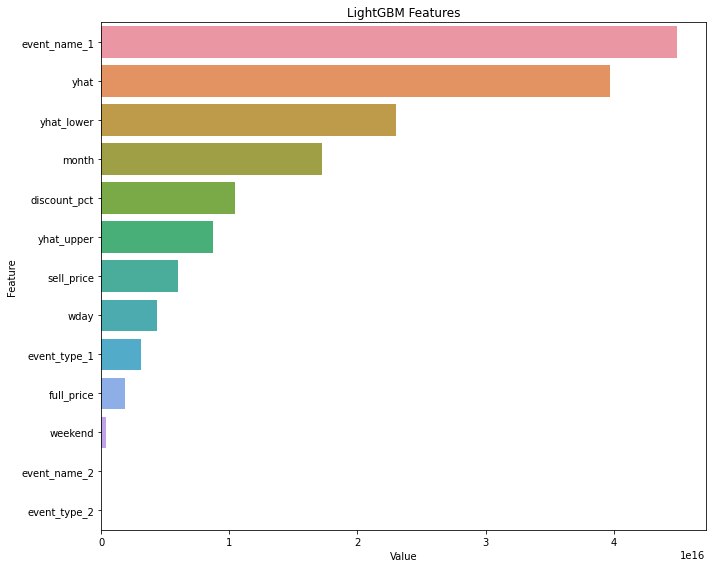

In [44]:
plotImp(lgb_model, df_train[variables], 20)

In [45]:
df_cat_all = df_cat.groupby("ds").agg({"y":"sum","yhat":"sum","prediccion_unidades_lgb":"sum"}).reset_index()

In [46]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df_cat_all["ds"], y=df_cat_all["y"],
                          mode='lines',
                          name='Sales',
                          marker_color='rgb(121,121,121)'))
fig.add_trace(go.Scatter(x=df_cat_all["ds"], y=df_cat_all["yhat"],
                          mode='lines+markers',
                          name='Prediction Prophet',
                          marker_color='rgb(16,52,166)'))
fig.add_trace(go.Scatter(x=df_cat_all["ds"], y=df_cat_all["prediccion_unidades_lgb"],
                          mode='lines+markers',
                          name='Prediction Prophet+Ligthgbm',
                          marker_color='rgb(70,194,173)'))

fig.update_traces(mode='markers+lines')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout({
    'height': 800,
    'template': 'plotly_white',
    'plot_bgcolor': 'rgba(0,0,0,0)',
    'paper_bgcolor': 'rgba(0,0,0,0)',
    'xaxis_title': 'Fecha',
    'yaxis_title': 'Unidades',
    'yaxis_tickformat': ',.0f',
    'yaxis.rangemode': 'tozero',
    'legend': {'orientation': 'h',
                'yanchor': 'bottom',
                'y': 1.02,
                'xanchor': 'right',
                'x': 1
                }
})